**Necessary Imports**

In [ ]:
###
import tensorflow as tf
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import VGG16
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [ ]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.12.0


**Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ThesisExperimentsFinal/Dataset/sepakmed.zip

**Data Visualisation**

In [ ]:
save_path = '/content/drive/MyDrive/ThesisExperimentsFinal/FineTunedandCostSensitive/Vgg16/Model/'

In [ ]:
Path= "/content/sepakmed"
Path = pathlib.Path(Path)

In [ ]:
dyskeratotic = [fn for fn in os.listdir(f'{Path}/im_Dyskeratotic') if fn.endswith('.bmp')]
koilocytotic = [fn for fn in os.listdir(f'{Path}/im_Koilocytotic') if fn.endswith('.bmp')]
metaplastic = [fn for fn in os.listdir(f'{Path}/im_Metaplastic') if fn.endswith('.bmp')]
parabasal = [fn for fn in os.listdir(f'{Path}/im_Parabasal') if fn.endswith('.bmp')]
superficial_intermediate = [fn for fn in os.listdir(f'{Path}/im_Superficial-Intermediate') if fn.endswith('.bmp')]
cancer= [dyskeratotic, koilocytotic, metaplastic, parabasal, superficial_intermediate]
cancer_classes = []

cancer_classes = [i.replace('im_', '') for i in os.listdir('/content/sepakmed')]
cancer_classes.sort()

print(cancer_classes)

['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']


Total images: 4049
Total number of classes: 5
Total Dyskeratotic images: 813
Total Koilocytotic images: 825
Total Metaplastic images: 793
Total Parabasal images: 787
Total Superficial-Intermediate images: 831


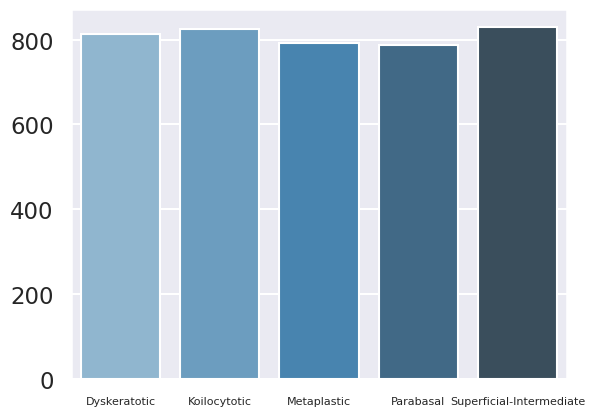

In [ ]:
image_count = len(list(Path.glob('*/*.bmp')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(cancer_classes)}')
count = 0
cancer_count = []
for x in cancer_classes:
  print(f'Total {x} images: {len(cancer[count])}')
  cancer_count.append(len(cancer[count]))
  count += 1

sns.set_style('darkgrid')
sns.set_context('talk') # set overall font size

sns.barplot(x=cancer_classes, y=cancer_count, palette='Blues_d')
plt.xticks(fontsize=8) # set x-axis font size
plt.show()

Image dimensions: (102, 86, 3)


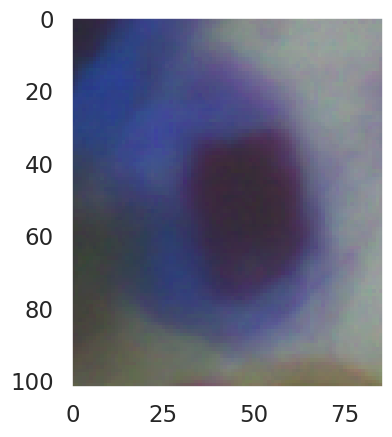

In [ ]:
sample_img = cv2.imread('/content/sepakmed/im_Dyskeratotic/001_02.bmp')
plt.imshow(sample_img)
plt.grid(False) # turn off grid lines
print(f'Image dimensions: {sample_img.shape}')


In [ ]:
def load_random_img(dir, label):
  plt.figure(figsize=(15,15))
  i=0
  for label in cancer_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{"im_"+label}'))
    image_path = os.path.join(f'{dir}/{"im_"+label}', file)
    img=cv2.imread(image_path)
    plt.title(label, fontsize=12) # set title font size to 12
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')


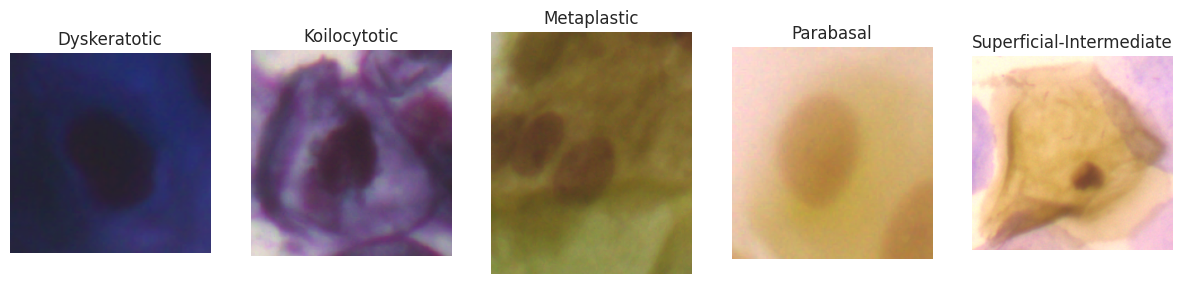

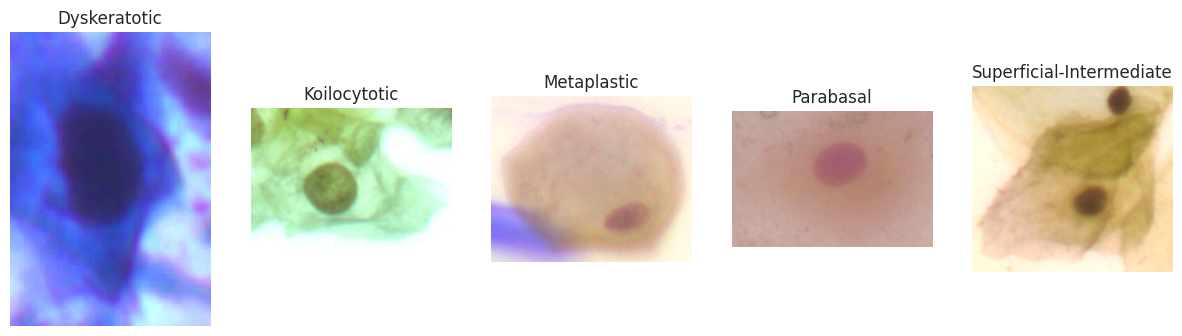

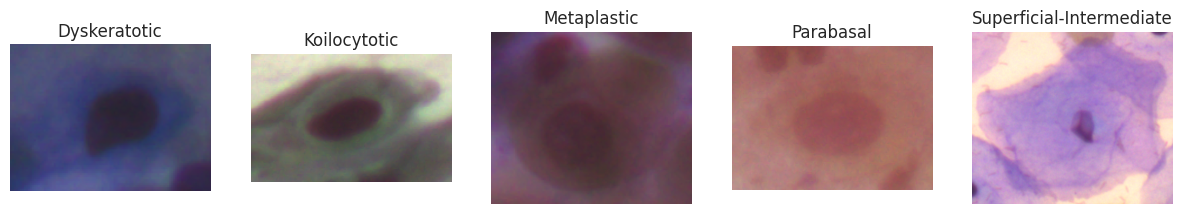

In [ ]:
for i in range(3):
  load_random_img(Path, cancer_classes)

In [ ]:
import os
from PIL import Image

max_height = 999
max_width = 999
max_image = ""

for root, dirs, files in os.walk("/content/sepakmed"):
    for file in files:
        if file.endswith(".bmp"):
            # Open the image using PIL
            img = Image.open(os.path.join(root, file))

            # Get the dimensions of the image
            width, height = img.size

            # Update the maximum height, width, and image name
            if height < max_height:
                max_height = height
                max_image = file
            if width < max_width:
                max_width = width
                max_image = file

print("Minimum image size in our dataset:")
print(f"Image: {max_image}")
print(f"Minimum Height: {max_height}")
print(f"Minimum Width: {max_width}")

Minimum image size in our dataset:
Image: 037_03.bmp
Minimum Height: 48
Minimum Width: 62


In [ ]:
import os
from PIL import Image

max_height = 0
max_width = 0
max_image = ""

for root, dirs, files in os.walk("/content/sepakmed"):
    for file in files:
        if file.endswith(".bmp"):
            # Open the image using PIL
            img = Image.open(os.path.join(root, file))

            # Get the dimensions of the image
            width, height = img.size

            # Update the maximum height, width, and image name
            if height > max_height:
                max_height = height
                max_image = file
            if width > max_width:
                max_width = width
                max_image = file

print("Maximum image size in our dataset:")
print(f"Image: {max_image}")
print(f"Maximum Height: {max_height}")
print(f"Maximum Width: {max_width}")

Maximum image size in our dataset:
Image: 026_04.bmp
Maximum Height: 553
Maximum Width: 531


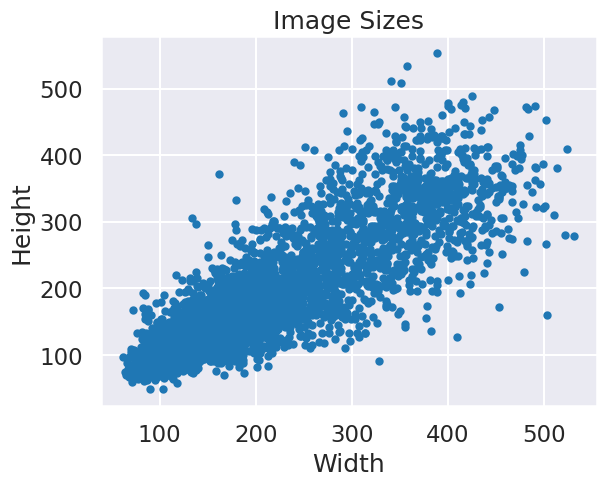

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Create empty lists to store the heights and widths
heights = []
widths = []

for root, dirs, files in os.walk("/content/sepakmed"):
    for file in files:
        if file.endswith(".bmp"):
            # Open the image using PIL
            img = Image.open(os.path.join(root, file))

            # Get the dimensions of the image
            width, height = img.size

            # Append the height and width to the corresponding list
            heights.append(height)
            widths.append(width)

# Create a scatter plot of the heights and widths
plt.scatter(widths, heights, marker=".")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Sizes")

# Show the plot
plt.show()


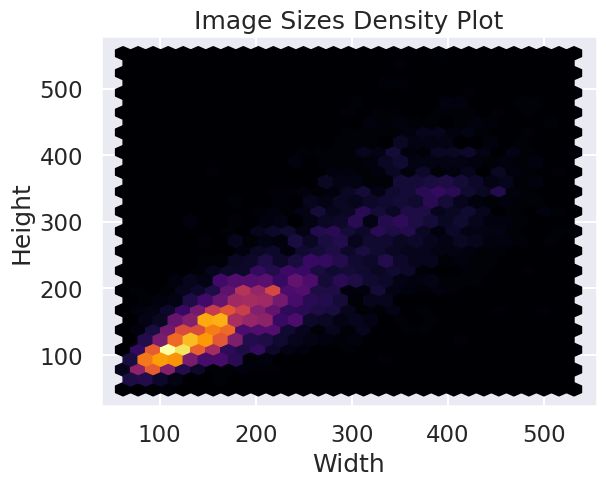

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Create empty lists to store the heights and widths
heights = []
widths = []

for root, dirs, files in os.walk("/content/sepakmed"):
    for file in files:
        if file.endswith(".bmp"):
            # Open the image using PIL
            img = Image.open(os.path.join(root, file))

            # Get the dimensions of the image
            width, height = img.size

            # Append the height and width to the corresponding list
            heights.append(height)
            widths.append(width)

# Create a 2D density plot of the heights and widths
plt.hexbin(widths, heights, gridsize=30, cmap="inferno")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Sizes Density Plot")

# Show the plot
plt.show()


In [ ]:
import os
import numpy as np
from PIL import Image


heights = []
widths = []
total_images = 0

for root, dirs, files in os.walk("/content/sepakmed"):
    for file in files:
        if file.endswith(".bmp"):
            img = Image.open(os.path.join(root, file))

            width, height = img.size

            # Append the height and width to the corresponding list
            heights.append(height)
            widths.append(width)
            
            total_images += 1

# Create a 2D histogram of the heights and widths
hist, x_edges, y_edges = np.histogram2d(heights, widths, bins=30)

# Find the bin with the highest count
max_bin = np.unravel_index(np.argmax(hist), hist.shape)

# Print the value of the most dense bin
print("Most dense height:", y_edges[max_bin[0]])
print("Most dense width:", x_edges[max_bin[1]])

print("Total images counted:", total_images)


Most dense height: 108.9
Most dense width: 98.5
Total images counted: 4049


**Dataset Division**

In [ ]:
#Class function for dataset division

class DatasetDivision:
	def __init__(self, root_dir="",output_dir=""):
		self.root_dir = root_dir
		self.output_dir = output_dir
		print("Instance of the class created")
  
	def printnow(self, new_dir):
		print("Just testing that the method calling is working: "+new_dir)
  
	def divide_dataset(self, root_dir, output_dir):
		self.root_dir =root_dir
		self.output_dir = output_dir

		if os.path.exists(self.output_dir):
			if not os.path.exists(os.path.join(self.output_dir,'train')):
				os.mkdir(os.path.join(self.output_dir,'train')) 
				os.mkdir(os.path.join(self.output_dir,'val'))
				os.mkdir(os.path.join(self.output_dir,'test')) 
		else:
			os.mkdir(self.output_dir)
			os.mkdir(os.path.join(self.output_dir,'train'))
			os.mkdir(os.path.join(self.output_dir, 'val'))
			os.mkdir(os.path.join(self.output_dir, 'test'))
   
		# Split train/val/test sets
		for file in os.listdir(root_dir):             
			classes_path = os.path.join(root_dir, file)  
			class_files = [name for name in glob.glob(os.path.join(classes_path,'*.bmp'))] 
			train_and_valid, test = train_test_split(class_files, train_size=0.80, test_size=0.20, random_state=42)  #For the test dataset will be 20% of the dataset - sklearn function#
			train, val = train_test_split(train_and_valid, train_size=0.80, test_size=0.20, random_state=42)  #For the validation dataset will be 20% of the dataset , leaving 60% for training#

			#Creating new training, validation and testing directories that the frame folders will be moved to.
			train_dir = os.path.join(self.output_dir, 'train',file) #creates the train data path for divided dataset 
			val_dir = os.path.join(self.output_dir, 'val', file) #creates the validation data path for divided dataset 
			test_dir = os.path.join(self.output_dir, 'test',file) #creates the test data path for divided dataset 
			if not os.path.exists(train_dir):
				os.mkdir(train_dir)
			if not os.path.exists(val_dir):
				os.mkdir(val_dir)
			if not os.path.exists(test_dir):
				os.mkdir(test_dir)

			for frame_folders in train:
				#get only the last directory of the path frame_folders
				frame_folder = os.path.join(root_dir,file,frame_folders)
				shutil.move(frame_folder,train_dir)
			for frame_folders in val:
				frame_folder = os.path.join(root_dir,file,frame_folders)
				shutil.move(frame_folder,val_dir)
			for frame_folders in test:
				frame_folder = os.path.join(root_dir,file,frame_folders)
				shutil.move(frame_folder,test_dir)
    
print('Dataset Division Completed.')

Dataset Division Completed.


In [ ]:
path_dir= "/content/sepakmed/"
output_dir = "/content/OurDataset"
datasetdiv = DatasetDivision(path_dir,output_dir)
datasetdiv.printnow("Working")
datasetdiv.divide_dataset(path_dir, output_dir)

Instance of the class created
Just testing that the method calling is working: Working


**Data Augumentation**

In [ ]:
#Class for data augmentation using geometric function

class DataAugmentation:
	def __init__(self, root_dir="",output_dir=""):
		self.root_dir = root_dir
		self.output_dir = output_dir
		print("Instance of the DataAugmentation class created")

	def augmentation_of_image(self, test_image, output_path):
		self.test_image = test_image;
		self.output_path = output_path;
		#define the Augmenters

		#properties: A range of values signifies that one of these numbers is randmoly chosen for every augmentation for every batch

		# Apply affine transformations to each image.
		rotate = iaa.Affine(rotate=(-90,90));  
		scale = iaa.Affine(scale={"x": (0.5, 0.9), "y": (0.5,0.9)}); 
		translation = iaa.Affine(translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)});
		shear = iaa.Affine(shear=(-2, 2)); #plagio parallhlogrammo wihthin a range (-8,8)
		zoom = iaa.PerspectiveTransform(scale=(0.01, 0.15), keep_size=True) # do not change the output size of the image
		h_flip = iaa.Fliplr(1.0); # flip horizontally all images (100%)
		v_flip = iaa.Flipud(1.0); #flip vertically all images
		padding=iaa.KeepSizeByResize(iaa.CropAndPad(percent=(0.05, 0.25)))#positive values correspond to padding 5%-25% of the image,but keeping the origial output size of the new image


		#More augmentations
		blur = iaa.GaussianBlur(sigma=(0, 1.22)) # blur images with a sigma 0-2,a number ofthis range is randomly chosen everytime.Low values suggested for this application
		contrast = iaa.contrast.LinearContrast((0.75, 1.5)); #change the contrast by a factor of 0.75 and 1.5 sampled randomly per image
		contrast_channels = iaa.LinearContrast((0.75, 1.5), per_channel=True) #and for 50% of all images also independently per channel:
		sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)); #sharpen with an alpha from 0(no sharpening) - 1(full sharpening) and change the lightness form 0.75 to 1.5 
		gauss_noise = iaa.AdditiveGaussianNoise(scale=0.111*255, per_channel=True) #some random gaussian noise might occur in cell images,especially when image quality is poor
		laplace_noise = iaa.AdditiveLaplaceNoise(scale=(0, 0.111*255)) #we choose to be in a small range, as it is logical for training the cell images


		#Brightness 
		brightness = iaa.Multiply((0.35,1.65)) #change brightness between 35% or 165% of the original image
		brightness_channels = iaa.Multiply((0.5, 1.5), per_channel=0.75) # change birghtness for 25% of images.For the remaining 75%, change it, but also channel-wise.

		#CHANNELS (RGB)=(Red,Green,Blue)
		red =iaa.WithChannels(0, iaa.Add((10, 100))) #increase each Red-pixels value within the range 10-100
		red_rot = iaa.WithChannels(0,iaa.Affine(rotate=(0, 45))) #rotate each image's red channel by 0-45 degrees
		green= iaa.WithChannels(1, iaa.Add((10, 100)))#increase each Green-pixels value within the range 10-100
		green_rot=iaa.WithChannels(1,iaa.Affine(rotate=(0, 45))) #rotate each image's green channel by 0-45 degrees
		blue=iaa.WithChannels(2, iaa.Add((10, 100)))#increase each Blue-pixels value within the range 10-100
		blue_rot=iaa.WithChannels(2,iaa.Affine(rotate=(0, 45))) #rotate each image's blue channel by 0-45 degrees

		#colors
		channel_shuffle =iaa.ChannelShuffle(1.0); #shuffle all images of the batch
		grayscale = iaa.Grayscale(1.0)
		hue_n_saturation = iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True) #change hue and saturation with this range of values for different values 
		add_hue_saturation = iaa.AddToHueAndSaturation((-50, 50), per_channel=True) #add more hue and saturation to its pixels
		#Quantize colors using k-Means clustering
		kmeans_color = iaa.KMeansColorQuantization(n_colors=(4, 16)) #quantizes to k means 4 to 16 colors (randomly chosen). Quantizes colors up to 16 colors

		#Alpha Blending 
		blend =iaa.AlphaElementwise((0, 1.0), iaa.Grayscale((0,1.0))) ; #blend depending on which value is greater

		#Contrast augmentors
		clahe = iaa.CLAHE(tile_grid_size_px=((3, 21),[0,2,3,4,5,6,7])) #create a clahe contrast augmentor H=(3,21) and W=(0,7)
		histogram = iaa.HistogramEqualization() #performs histogram equalization

		#Augmentation list of metadata augmentors
		OneofRed = iaa.OneOf( [red]);
		OneofGreen = iaa.OneOf( [green] );
		OneofBlue = iaa.OneOf( [blue]);
		contrast_n_shit = iaa.OneOf([contrast, brightness, brightness_channels]);
		SomeAug = iaa.SomeOf(2,[rotate,scale, translation, shear, h_flip,v_flip],random_order=True);
		SomeClahe = iaa.SomeOf(2, [clahe, iaa.CLAHE(clip_limit=(1, 10)),iaa.CLAHE(tile_grid_size_px=(3, 21)),iaa.GammaContrast((0.5, 2.0)), iaa.AllChannelsCLAHE() , iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)],random_order=True) #Random selection from clahe augmentors
		edgedetection= iaa.OneOf([iaa.EdgeDetect(alpha=(0, 0.7)),iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0))]);# Search in some images either for all edges or for directed edges.These edges are then marked in a black and white image and overlayed with the original image using an alpha of 0 to 0.7.
		canny_filter = iaa.OneOf([iaa.Canny(), iaa.Canny(alpha=(0.5, 1.0), sobel_kernel_size=[3, 7])]); #choose one of the 2 canny filter options
		OneofNoise = iaa.OneOf([blur, gauss_noise, laplace_noise])
		Color_1 = iaa.OneOf([channel_shuffle,grayscale, hue_n_saturation , add_hue_saturation, kmeans_color]);
		Color_2 = iaa.OneOf([channel_shuffle,grayscale, hue_n_saturation , add_hue_saturation, kmeans_color]);
		Flip = iaa.OneOf([histogram , v_flip, h_flip]);

		#Define the augmentors used in the DA
		Augmentors= [SomeAug, SomeClahe, edgedetection, canny_filter, Color_1, contrast_n_shit]


		for i in range(0,6):
			img = cv2.imread(test_image) #read you image
			images = np.array([img for _ in range(6)], dtype=np.uint8)  # 12 is the size of the array that will hold 8 different images
			images_aug = Augmentors[i].augment_images(images)  #alternate between the different augmentors for a test image
			filename = os.path.splitext(test_image)[0] # get the filename without the extension
			cv2.imwrite(os.path.join(output_path, filename + '_new' + str(i) + '.jpg'), images_aug[i])



In [ ]:
import shutil
class DataAugmentation_Extension:

	def __init__(self, directory=""):
		self.directory = directory
		print("Instance of DataAugmentation_Extension class created")

	def printnow(self, dir):
		print("Just testing that the method calling is working "+ dir)


	def extend_dataset(self,directory):
		#Create an instance of class 
		print("HEY")
		library_augment= DataAugmentation();
		self.directory = directory 
		if not os.path.exists(self.directory):
			print("ERROR! Couldn't find directory!")
		else:
			print("Directory exists")
		for file in os.listdir(directory):            #for any file inside the root directory 
			classes_path = os.path.join(directory, file)  #So for every folder class we create a class directory
			class_files = [name for name in glob.glob(os.path.join(classes_path,'*.bmp'))]  #alternatively we can use the globe as mentioned
			print(class_files); #call augmentation for all class_files
			for i in range(len(class_files)):
				library_augment.augmentation_of_image(class_files[i], classes_path)
		

In [ ]:
#data augmentation
#directories
target_directory = "/content/OurDataset/train"
#create an instance of the class
datasetda = DataAugmentation_Extension()
datasetda.extend_dataset(target_directory)

Instance of DataAugmentation_Extension class created
HEY
Instance of the DataAugmentation class created
Directory exists
['/content/OurDataset/train/im_Koilocytotic/139_02.bmp', '/content/OurDataset/train/im_Koilocytotic/162_02.bmp', '/content/OurDataset/train/im_Koilocytotic/097_03.bmp', '/content/OurDataset/train/im_Koilocytotic/121_05.bmp', '/content/OurDataset/train/im_Koilocytotic/071_02.bmp', '/content/OurDataset/train/im_Koilocytotic/148_02.bmp', '/content/OurDataset/train/im_Koilocytotic/053_01.bmp', '/content/OurDataset/train/im_Koilocytotic/013_03.bmp', '/content/OurDataset/train/im_Koilocytotic/119_08.bmp', '/content/OurDataset/train/im_Koilocytotic/046_01.bmp', '/content/OurDataset/train/im_Koilocytotic/111_08.bmp', '/content/OurDataset/train/im_Koilocytotic/074_02.bmp', '/content/OurDataset/train/im_Koilocytotic/126_04.bmp', '/content/OurDataset/train/im_Koilocytotic/049_01.bmp', '/content/OurDataset/train/im_Koilocytotic/105_01.bmp', '/content/OurDataset/train/im_Koilocyt

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `AlphaElementwise()` is deprecated. Use `AlphaElementwise` instead. AlphaElementwise is deprecated. Use BlendAlphaElementwise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


['/content/OurDataset/train/im_Parabasal/001_09.bmp', '/content/OurDataset/train/im_Parabasal/098_08.bmp', '/content/OurDataset/train/im_Parabasal/010_04.bmp', '/content/OurDataset/train/im_Parabasal/028_02.bmp', '/content/OurDataset/train/im_Parabasal/041_04.bmp', '/content/OurDataset/train/im_Parabasal/004_11.bmp', '/content/OurDataset/train/im_Parabasal/100_12.bmp', '/content/OurDataset/train/im_Parabasal/001_06.bmp', '/content/OurDataset/train/im_Parabasal/053_01.bmp', '/content/OurDataset/train/im_Parabasal/013_03.bmp', '/content/OurDataset/train/im_Parabasal/044_07.bmp', '/content/OurDataset/train/im_Parabasal/046_01.bmp', '/content/OurDataset/train/im_Parabasal/012_03.bmp', '/content/OurDataset/train/im_Parabasal/031_06.bmp', '/content/OurDataset/train/im_Parabasal/086_11.bmp', '/content/OurDataset/train/im_Parabasal/063_03.bmp', '/content/OurDataset/train/im_Parabasal/071_06.bmp', '/content/OurDataset/train/im_Parabasal/074_04.bmp', '/content/OurDataset/train/im_Parabasal/069_1

In [ ]:
import os
import glob
import cv2

# Get a list of all the bmp files in the directory
bmp_files = glob.glob('/content/OurDataset/*/*/*.bmp')

# Iterate over each bmp file and convert it to jpg
for bmp_file in bmp_files:
    img = cv2.imread(bmp_file)
    jpg_file = os.path.splitext(bmp_file)[0] + '.jpg'
    cv2.imwrite(jpg_file, img)
    os.remove(bmp_file)  # Remove the original bmp file


In [ ]:
path= "/content/OurDataset/"

# Image data generator with data augmentation (train_datagen)
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   rotation_range = 5, fill_mode="nearest",
                                   zoom_range=[1/1.0, 1/1.0], width_shift_range=0.0, height_shift_range=0.0,
                                   horizontal_flip = True, vertical_flip=True,
                                   brightness_range=[0.5, 1.3], channel_shift_range=20)

no_DA_IDG = ImageDataGenerator()

# training set: use data augmentation image data generator, for validation and test: no data augmentation.
training_set = train_datagen.flow_from_directory(path+"train/",
                                                target_size=(110, 110), # optimal size for our dataset
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical', shuffle=True)



validation_set = no_DA_IDG.flow_from_directory(path+"val/",
                                                target_size=(110, 110),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                shuffle=True)



test_set = no_DA_IDG.flow_from_directory(path+"test/",
                                                target_size=(110, 110),
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)

Found 18123 images belonging to 5 classes.
Found 648 images belonging to 5 classes.
Found 812 images belonging to 5 classes.


In [ ]:
dyskeratotic = [fn for fn in os.listdir(f'{path}/train/im_Dyskeratotic') if fn.endswith('.jpg')]
koilocytotic = [fn for fn in os.listdir(f'{path}/train/im_Koilocytotic') if fn.endswith('.jpg')]
metaplastic = [fn for fn in os.listdir(f'{path}/train/im_Metaplastic') if fn.endswith('.jpg')]
parabasal = [fn for fn in os.listdir(f'{path}/train/im_Parabasal') if fn.endswith('.jpg')]
superficial_intermediate = [fn for fn in os.listdir(f'{path}/train/im_Superficial-Intermediate') if fn.endswith('.jpg')]
cancer= [dyskeratotic, koilocytotic, metaplastic, parabasal, superficial_intermediate]
cancer_classes = []
cancer_classes = [i.replace('im_', '') for i in os.listdir('/content/OurDataset/train')]
cancer_classes.sort()

print(cancer_classes)


['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']


Total images: 19583
Total number of classes: 5
Total Dyskeratotic images: 3640
Total Koilocytotic images: 3696
Total Metaplastic images: 3549
Total Parabasal images: 3521
Total Superficial-Intermediate images: 3717


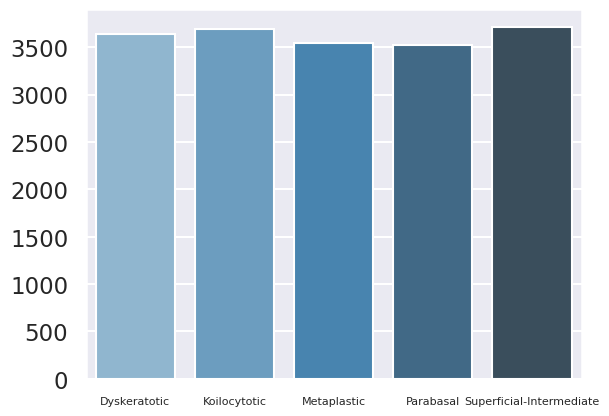

In [ ]:
Path= "/content/OurDataset/"
Path = pathlib.Path(Path)

image_count = len(list(Path.glob('*/*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(cancer_classes)}')

count = 0
cancer_count = []
for x in cancer_classes:
  print(f'Total {x} images: {len(cancer[count])}')
  cancer_count.append(len(cancer[count]))
  count += 1

sns.set_style('darkgrid')
sns.set_context('talk') # set overall font size

sns.barplot(x=cancer_classes, y=cancer_count, palette='Blues_d')
plt.xticks(fontsize=8) # set x-axis font size
plt.show()

In [ ]:
Dyskeratotic= glob.glob('/content/OurDataset/train/im_Dyskeratotic/*.*')
Koilocytotic = glob.glob('/content/OurDataset/train/im_Koilocytotic/*.*')
Metaplastic = glob.glob('/content/OurDataset/train/im_Metaplastic/*.*')
Parabasal = glob.glob('/content/OurDataset/train/im_Parabasal/*.*')
SuperficialIntermediate = glob.glob('/content/OurDataset/train/im_Superficial-Intermediate/*.*')

In [ ]:
dataset = {0 :Dyskeratotic, 1:Koilocytotic, 2:Metaplastic, 3:Parabasal, 4:SuperficialIntermediate}

In [ ]:
def combineDataAndLabel(width, height, dataset):
  
  traindata = []
  trainlabels = []
  count = 0

  for cls in dataset:
      print(f"\n\nconverting {cls} \n\n")
      for i in dataset[cls]:
          print(f"\nconverting image:  {i}")
          image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
          target_size= (width,height))
          image=np.array(image)
          traindata.append(image)
          count=count+1
          trainlabels.append(cls)
      print(f"\n\processed {count} images \n\n")

  train_data = np.array(traindata)
  train_labels = np.array(trainlabels)

  print(f"\n\nSaving to drive\n\n")
  np.save('/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainData', train_data)
  np.save('/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainLabels', train_labels)
  print(f"\n\nSaved")

  return train_data, train_labels

In [ ]:
import os
train_data = []
train_labels = []
if(os.path.isfile("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainData.npy") and os.path.isfile("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainLabels.npy")):
  train_data = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainData.npy")
  train_labels = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainLabels.npy")
else:
  train_data, train_labels = combineDataAndLabel(110,110,dataset)

Streaming output truncated to the last 5000 lines.

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/067_06_new0.jpg

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/007_03_new1.jpg

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/116_03_new2.jpg

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/071_04_new2.jpg

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/002_06_new5.jpg

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/118_10.jpg

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/100_03_new2.jpg

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/083_04_new2.jpg

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/119_01_new0.jpg

converting image:  /content/OurDataset/train/im_Superficial-Intermediate/055_03.jpg

converting image:  /content/OurDataset/train/im_Superficia

In [ ]:
Dyskeratotic= glob.glob('/content/OurDataset/val/im_Dyskeratotic/*.*')
Koilocytotic = glob.glob('/content/OurDataset/val/im_Koilocytotic/*.*')
Metaplastic = glob.glob('/content/OurDataset/val/im_Metaplastic/*.*')
Parabasal = glob.glob('/content/OurDataset/val/im_Parabasal/*.*')
SuperficialIntermediate = glob.glob('/content/OurDataset/val/im_Superficial-Intermediate/*.*')

In [ ]:
dataset = {0 :Dyskeratotic, 1:Koilocytotic, 2:Metaplastic, 3:Parabasal, 4:SuperficialIntermediate}

In [ ]:
def combineDataAndLabel(width, height, dataset):
  
  valdata = []
  vallabels = []
  count = 0

  for cls in dataset:
      print(f"\n\nconverting {cls} \n\n")
      for i in dataset[cls]:
          print(f"\nconverting image:  {i}")
          image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
          target_size= (width,height))
          image=np.array(image)
          valdata.append(image)
          count=count+1
          vallabels.append(cls)
      print(f"\n\processed {count} images \n\n")

  val_data = np.array(valdata)
  val_labels = np.array(vallabels)

  print(f"\n\nSaving to drive\n\n")
  np.save('/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValData', val_data)
  np.save('/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValLabels', val_labels)
  print(f"\n\nSaved")

  return val_data, val_labels

In [ ]:
import os
val_data = []
val_labels = []
if(os.path.isfile("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValData") and os.path.isfile("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValLabels")):
  val_data = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValData.npy")
  val_labels = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValLabels.npy")
else:
  val_data, val_labels = combineDataAndLabel(110,110,dataset)



converting 0 



converting image:  /content/OurDataset/val/im_Dyskeratotic/117_02.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/165_01.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/101_08.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/028_02.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/066_08.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/164_08.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/002_10.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/096_01.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/068_03.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/030_03.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/076_02.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/067_18.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic/164_18.jpg

converting image:  /content/OurDataset/val/im_Dyskeratotic

In [ ]:
Dyskeratotic= glob.glob('/content/OurDataset/test/im_Dyskeratotic/*.*')
Koilocytotic = glob.glob('/content/OurDataset/test/im_Koilocytotic/*.*')
Metaplastic = glob.glob('/content/OurDataset/test/im_Metaplastic/*.*')
Parabasal = glob.glob('/content/OurDataset/test/im_Parabasal/*.*')
SuperficialIntermediate = glob.glob('/content/OurDataset/test/im_Superficial-Intermediate/*.*')

In [ ]:
dataset = {0 :Dyskeratotic, 1:Koilocytotic, 2:Metaplastic, 3:Parabasal, 4:SuperficialIntermediate}

In [ ]:
def combineDataAndLabel(width, height, dataset):
  
  testdata = []
  testlabels = []
  count = 0

  for cls in dataset:
      print(f"\n\nconverting {cls} \n\n")
      for i in dataset[cls]:
          print(f"\nconverting image:  {i}")
          image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
          target_size= (width,height))
          image=np.array(image)
          testdata.append(image)
          count=count+1
          testlabels.append(cls)
      print(f"\n\processed {count} images \n\n")

  test_data = np.array(testdata)
  test_labels = np.array(testlabels)

  print(f"\n\nSaving to drive\n\n")
  np.save('/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestData', test_data)
  np.save('/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestLabels', test_labels)
  print(f"\n\nSaved")

  return test_data, test_labels

In [ ]:
import os
test_data = []
test_labels = []
if(os.path.isfile("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestData") and os.path.isfile("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestlLabels")):
  test_data = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestData.npy")
  test_labels = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestLabels.npy")
else:
  test_data, test_labels = combineDataAndLabel(110,110,dataset)



converting 0 



converting image:  /content/OurDataset/test/im_Dyskeratotic/184_01.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/151_01.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/101_16.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/169_01.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/022_02.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/220_04.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/104_04.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/028_01.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/092_02.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/095_02.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/102_09.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/221_05.jpg

converting image:  /content/OurDataset/test/im_Dyskeratotic/141_07.jpg

converting image:  /content/OurDataset/test/i